# Extraction of landscape geometry features

In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
import seaborn as sns
from scipy import spatial, stats

In [4]:
sns.set()

## Load the original data

Obtained from F. Poux's [video tutorial](https://www.youtube.com/watch?v=WKSJcG97gE4) on 3D point cloud feature extraction, available on [Google Drive](https://drive.google.com/drive/folders/1fwhE5OphpeW4RR0RY8W2jbqmlf5LH6dX).

In [5]:
fname = Path("data") / "UTWENTE" / "MLS_UTWENTE_super_sample.ply"
pcd = o3d.io.read_point_cloud(fname)

In [6]:
o3d.visualization.draw_geometries([pcd])

## Preprocessing

In [7]:
# Translation
zmin = pcd.get_min_bound()[2]
trans = np.array([0, 0, -zmin])
pcd = pcd.translate(trans)

In [8]:
# Colorization with regards to elevation
points = np.asarray(pcd.points)
elev = points[:, 2]
cmap = sns.color_palette(palette="viridis", as_cmap=True)
norm = plt.Normalize()
color = cmap(norm(elev))[:, :-1]
pcd.colors = o3d.utility.Vector3dVector(color)

In [9]:
o3d.visualization.draw_geometries([pcd])

## Exploring the unstructured data with an octree

In [10]:
octree = o3d.geometry.Octree(max_depth=7)
octree.convert_from_point_cloud(pcd, size_expand=0.01)

In [11]:
o3d.visualization.draw_geometries([octree])

## Downsampling the point cloud using a voxel grid

In [12]:
pcd_ds = pcd.voxel_down_sample(voxel_size=0.8)  # cca. 10x downsample

In [13]:
o3d.visualization.draw_geometries([pcd_ds])

## Removing outliers

In [ ]:
def display_inlier_outlier(
    pcd: o3d.geometry.PointCloud | np.ndarray,
    ind: np.ndarray,
) -> None:
    """Visualize inliers and outliers in a point cloud.

    Args:
        pcd (o3d.geometry.PointCloud | np.ndarray): Point cloud data.
        ind (np.ndarray): Indices of inlier points.

    Returns:
        None

    """
    if not isinstance(pcd, o3d.geometry.PointCloud):
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(np.asarray(pcd))
    inlier = pcd.select_by_index(ind)
    outlier = pcd.select_by_index(ind, invert=True)
    outlier.paint_uniform_color([1, 0, 0])
    inlier.paint_uniform_color([0.8, 0.8, 0.8])
    o3d.visualization.draw_geometries([inlier, outlier])

In [20]:
pcd_stat, ind = pcd_ds.remove_statistical_outlier(nb_neighbors=30, std_ratio=3)

In [22]:
display_inlier_outlier(pcd_ds, ind)

In [23]:
pcd_rad, ind = pcd_ds.remove_radius_outlier(nb_points=25, radius=5)

In [24]:
display_inlier_outlier(pcd_ds, ind)

In [25]:
o3d.visualization.draw_geometries([pcd_rad])

## Final cleaning touches on the point cloud

In [27]:
# https://www.open3d.org/html/tutorial/Advanced/interactive_visualization.html
# o3d.visualization.draw_geometries_with_editing([pcd_rad])

In [28]:
fname = Path("data") / "UTWENTE" / "MLS_UTWENTE_super_sample_crop.ply"
pcd_crop = o3d.io.read_point_cloud(fname)

In [29]:
o3d.visualization.draw_geometries([pcd_crop])

## Extracting geometric features

In [30]:
points = np.asarray(pcd_crop.points)

### In 3D

In [31]:
def pca(points: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """Return eigenvalues and eigenvectors from PCA on point cloud.

    Args:
        points (np.ndarray): Nx3 array of point cloud data.

    Returns:
        tuple[np.ndarray, np.ndarray]: Eigenvalues and eigenvectors in descending order.

    """
    points_norm = points - np.mean(points, axis=0)
    cov = np.cov(points_norm, rowvar=False)
    evalues, evectors = np.linalg.eig(cov)
    mask = np.argsort(evalues)[::-1]
    return evalues[mask], evectors[:, mask]

In [36]:
def extract_features(evalues: np.ndarray, evectors: np.ndarray) -> dict[str, float]:
    """Return geometric features based on eigenvalues and eigenvectors.

    https://doi.org/10.5194/isprsannals-II-5-W2-313-2013

    Args:
        evalues (np.ndarray): Eigenvalues from PCA.
        evectors (np.ndarray): Eigenvectors from PCA.

    Returns:
        dict[str, float]: Dictionary of geometric features.

    """
    planarity = (evalues[1] - evalues[2]) / evalues[0]
    linearity = (evalues[0] - evalues[1]) / evalues[0]
    omnivariance = (evalues[0] * evalues[1] * evalues[2]) ** (1 / 3)
    _, _, normal = evectors
    verticality = 1 - normal[2]
    return {
        "planarity": float(planarity),
        "linearity": float(linearity),
        "omnivariance": float(omnivariance),
        "verticality": float(verticality),
        "nx": float(normal[0]),
        "ny": float(normal[1]),
        "nz": float(normal[2]),
    }

In [37]:
tree = spatial.KDTree(points)
dist, ind = tree.query(points, k=25)
nbhd = points[ind]

In [38]:
# example for a single point
sel = 0
evalues, evectors = pca(nbhd[sel])
feats = extract_features(evalues, evectors)

In [39]:
feats

{'planarity': 0.28356258122852257,
 'linearity': 0.38839455868826467,
 'omnivariance': 1.0803330542707341,
 'verticality': 1.2763446566921832,
 'nx': 0.2777297741681752,
 'ny': 0.9200542393023214,
 'nz': -0.2763446566921833}

In [40]:
# surface normals
n = np.empty_like(points)
for i in range(points.shape[0]):
    evalues, evectors = pca(nbhd[i, ...])
    feats = extract_features(evalues, evectors)
    n[i, :] = [feats["nx"], feats["ny"], feats["nz"]]
pcd_crop.normals = o3d.utility.Vector3dVector(n)
pcd_crop.orient_normals_consistent_tangent_plane(20)

In [41]:
o3d.visualization.draw_geometries([pcd_crop], point_show_normal=True)

### 2D

In [ ]:
def display_selection(
    pcd: o3d.geometry.PointCloud | np.ndarray,
    ind: np.ndarray,
) -> None:
    """Show selected points in red and unselected in gray.

    Args:
        pcd (o3d.geometry.PointCloud | np.ndarray): Point cloud data.
        ind (np.ndarray): Indices of selected points

    Returns:
        None

    """
    if not isinstance(pcd, o3d.geometry.PointCloud):
        points = pcd
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(np.asarray(points))
    selected = pcd.select_by_index(ind)
    unselected = pcd.select_by_index(ind, invert=True)
    selected.paint_uniform_color([1, 0, 0])
    unselected.paint_uniform_color([0.8, 0.8, 0.8])
    o3d.visualization.draw_geometries([selected, unselected])

In [43]:
tree_2d = spatial.KDTree(points[:, :2])
ind_2d = tree_2d.query_ball_point(points[:, :2], 4)

In [44]:
# Example for a single selection
sel = 0
points_sel = points[ind_2d[sel]]

In [45]:
display_selection(points, ind_2d[sel])

In [ ]:
# Create a distribution of elevations of the scenary
elevs = []
for i in range(points.shape[0]):
    points_sel = points[ind_2d[i]]
    elevs.append(np.ptp(points_sel[:, 2]))

In [49]:
kernel = stats.gaussian_kde(elevs)

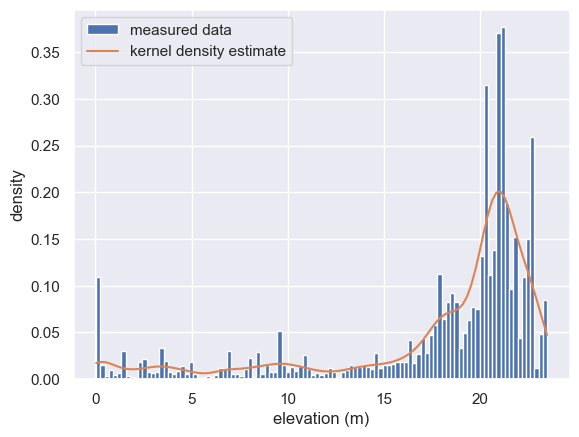

In [50]:
# Plot elevation distribution
fig, ax = plt.subplots()
y, bins, patches = ax.hist(
    elevs,
    bins="fd",
    density=True,
    cumulative=False,
    histtype="bar",
    align="mid",
    orientation="vertical",
    label="measured data",
)
ax.plot(bins, kernel(bins), label="kernel density estimate")
ax.set(xlabel="elevation (m)", ylabel="density")
ax.legend();

In [51]:
kernel.integrate_box_1d(min(elevs), max(elevs))

np.float64(0.9635174714039089)

In [52]:
kernel.integrate_box_1d(10, 15)

np.float64(0.060001396507266824)

In [53]:
kernel.covariance

array([[0.48386452]])

In [54]:
kernel.covariance_factor()

np.float64(0.11727856248680574)

## Extracting the flat terrain

In [55]:
def display_plane(pcd: o3d.geometry.PointCloud | np.ndarray, ind: np.ndarray) -> None:
    """Show planar points in red and non-planar in gray.

    Args:
        pcd (o3d.geometry.PointCloud | np.ndarray): Point cloud data.
        ind (np.ndarray): Indices of planar points.

    Returns:
        None

    """
    if not isinstance(pcd, o3d.geometry.PointCloud):
        points = pcd
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(np.asarray(points))
    planar = pcd.select_by_index(ind)
    nonplanar = pcd.select_by_index(ind, invert=True)
    planar.paint_uniform_color([1, 0, 0])
    nonplanar.paint_uniform_color([0.8, 0.8, 0.8])
    o3d.visualization.draw_geometries([planar, nonplanar])

In [56]:
o3d.utility.random.seed(42)

In [57]:
plane_model, ind = pcd_crop.segment_plane(
    distance_threshold=0.5,
    ransac_n=3,
    num_iterations=1000,
)

In [58]:
a, b, c, d = plane_model
print(f"implicit eqn. ({a:.2e}) x + ({b:.2e}) y + ({c:.2e}) z + ({d:.2e}) = 0")

implicit eqn. (-3.80e-03) x + (-3.63e-04) y + (1.00e+00) z + (-6.84e-03) = 0


In [60]:
display_plane(pcd_crop, ind)

## Estimating the surface area of the flat terrain

In [61]:
pcd_flat = pcd_crop.select_by_index(ind)
pcd_flat.paint_uniform_color(sns.color_palette()[0])
obb = pcd_flat.get_oriented_bounding_box()
obb.color = sns.color_palette()[1]

In [62]:
o3d.visualization.draw_geometries([pcd_flat, obb])

The surface area is approximated without taking accounting for the elevation of the flat terrain.

In [63]:
surface_area = obb.extent[0] * obb.extent[1]
surface_area

np.float64(8115.831840955261)